# Unemployment in SA: Exploring the relationship between multiple variables that may influence the unemployment rate of South Africa

The purpose of this notebook is to explore variables that could potetially have a relationship with our response variables, i.e unemployment rate.
<br>
<br>
We will first start of by exploring which varibles have a relationship with the unemployment rate then after use those variables to answer the following questions:
<br>
<br>
**Questions:**<br>
Is there a significant relationship between the variables identifed and the unemployment rate?
<br>
<br>
We will explore this relationship using the regression slope test that has a regression line of the format:
<br>
$$
Y=\beta_{i} X \ for \ i = 0,1,2...m
$$
Where $X$ are the selected variables and $\beta_{i}$ are the respective coefficients.Thus, the **hypothesis** is as follows:
$$
\begin{array}{l}{\mathrm{H}_{\mathrm{0}} : \beta_{0}=\beta_{1}=...=\beta_{m}=0} \\ {\mathrm{H}_{\mathrm{1}} : \beta_{i} \neq 0 } \ for \ at \ least\ one \ i\end{array}
$$

<br>
<br>
I will be using the $F$-test to simultaneously check the significance of a number of regression coefficients.

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.metrics import r2_score
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from statsmodels.formula.api import rlm
import statsmodels.api as sm
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

# Data Collection

### South African Reserve Bank Cleaned Economic Data

Data prepared for modelling from the South African Reserve Bank

This data can used for both regression and classification research questions i.e. forecast the unemployment rate.

The original data was sourced from https://www.resbank.co.za/en/home/what-we-do/statistics/releases/economic-and-financial-data-for-south-africa


### The full feature set
*These feature were accessed from the South African Reserve Bank.*

*There are **147 features in total**, these cover a significant portfion of the South African economy*

**The data from 1922-01-01 to 2020-01-01** if it used for unemployment forecasting, deleting redudant observations is helpful

In [2]:
feature_set_sarb = pd.read_csv('sarb_features_data.csv').drop(['unemployment rate'], axis=1).set_index('Date')
target = pd.read_csv('sarb_target_data.csv').set_index('Date')

# Data Preparation

## Missing Data 

The missing data occurs because we are merging data that is monthly and data that is quartely, hence all quartely data should be expected to have missing data. This is normal when dealing with multiple time series.

In [3]:
#Here we visualize the frequency of missingness of each feature
feature = feature_set_sarb.isna().sum()/len(feature_set_sarb)

feature = feature.sort_values(ascending=False)
feature_df = pd.DataFrame(feature.index, columns=['Feature Name'])
feature_df['Missing Frequency'] = np.array(feature.values)
feature_df['Rank'] = feature_df['Missing Frequency'].rank(ascending=False)
#feature_df
feature_df

,Feature Name,Missing Frequency,Rank
0,Loans _y,0.986732,1.0
1,Consolidated general government: Liabilities: ...,0.959497,2.0
2,The difference between cash-flow revenue and c...,0.958799,3.0
3,Total South African population,0.958101,4.0
4,Foreign debt of S.A.: Total foreign debt,0.953212,5.0
...,...,...,...
142,Total gross loan debt (nsa),0.497207,132.0
143,The net borrowing requirement of national gove...,0.497207,132.0
144,Total outstanding domestic marketable bills,0.497207,132.0
145,Foreign exchange rate : SA rand per USA dollar,0.496508,146.0


<BarContainer object of 147 artists>

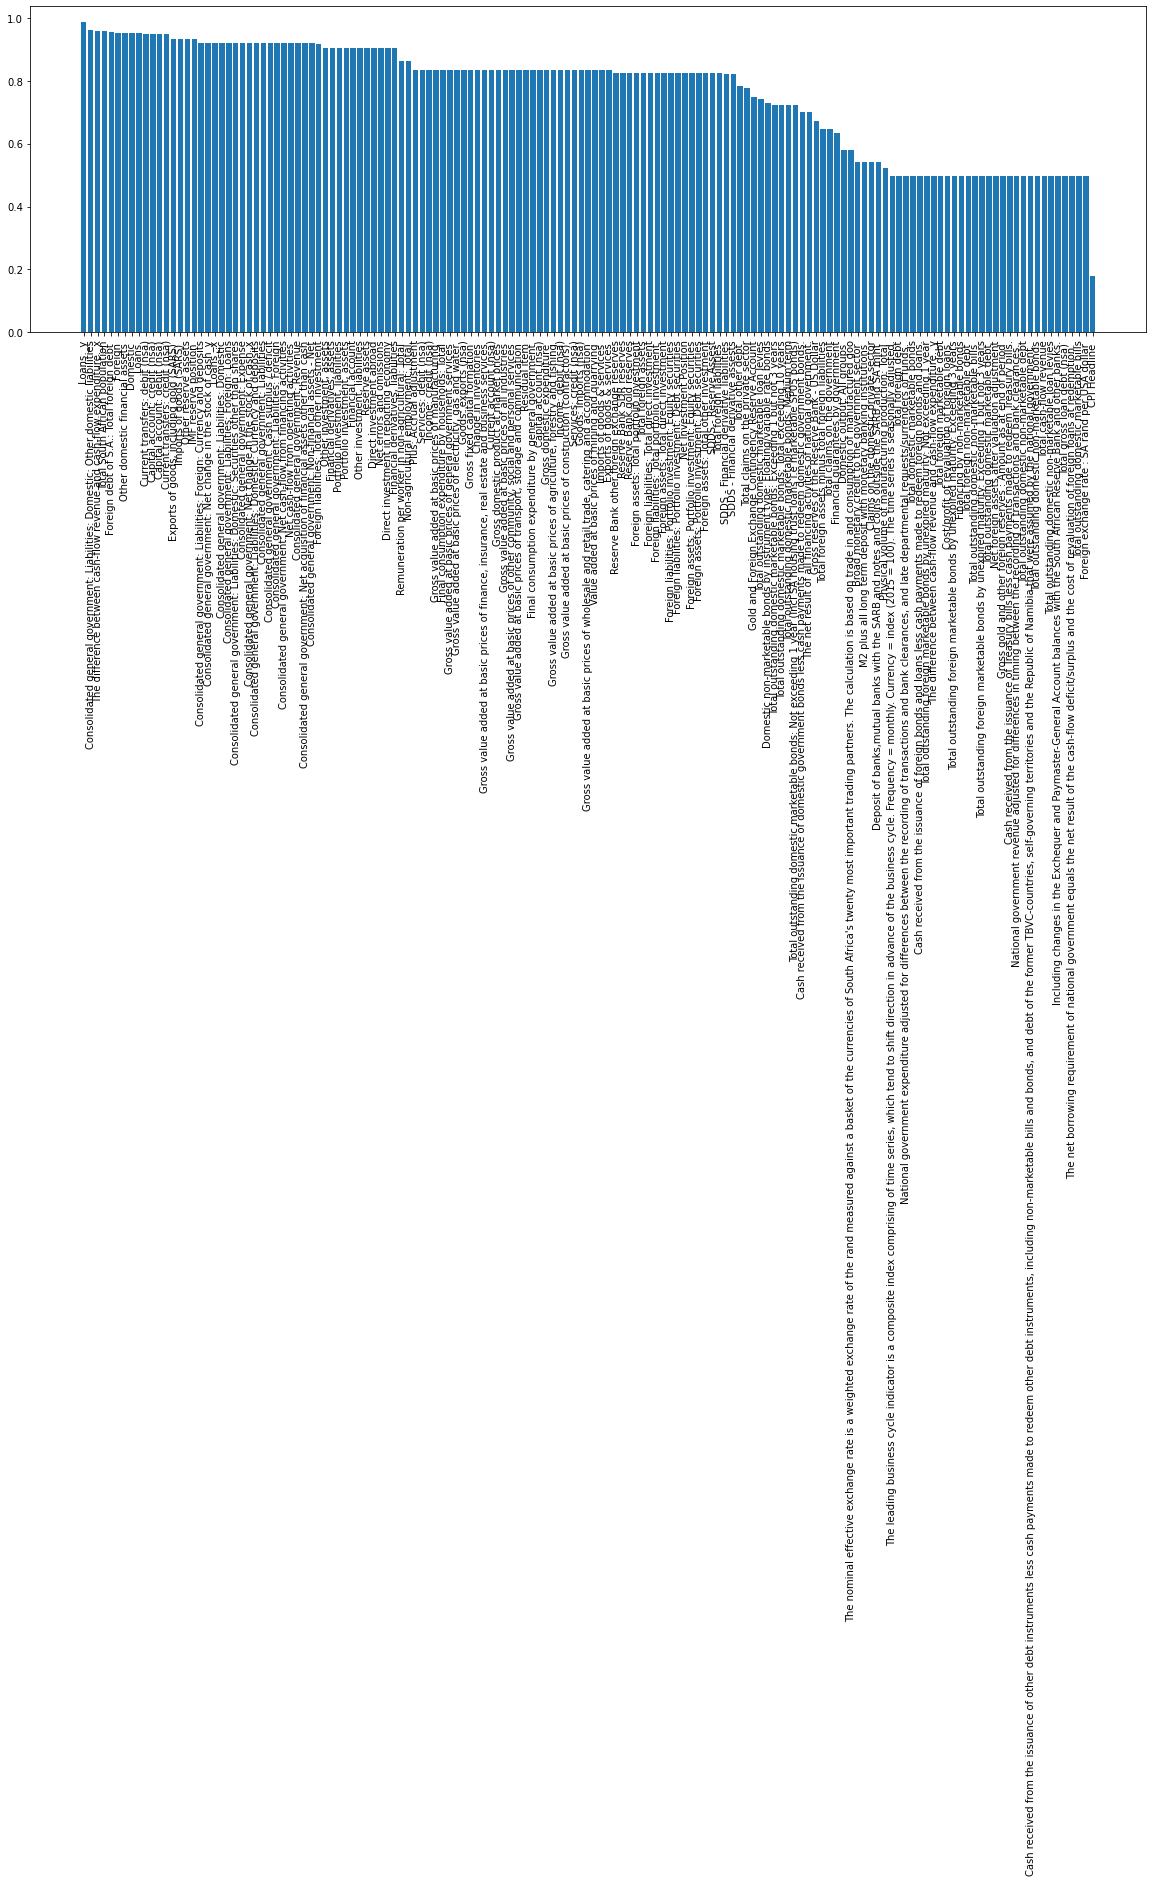

In [4]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
plt.bar(feature_df['Feature Name'], feature_df['Missing Frequency'])

## Imputation

In [5]:
# Data imputation strategy is foward fill i.e last know value imputation
# Economic data usually does not change that much from month to month.
x_values_ffill = feature_set_sarb.fillna(method='ffill')
y_values_ffill = target.fillna(method='ffill')

In [6]:
# Remove all data points before unemployment rate data is available. Unemployment rate is my target variable.
valid_start = y_values_ffill.first_valid_index()
y_values_ffill = y_values_ffill[valid_start : ]
x_values_ffill = x_values_ffill[valid_start : ]

In [7]:
#We fill with NA here to avoid any features that might be NA i.e. insurance
x_values_ffill = x_values_ffill.fillna(0)
x_values_ffill.isna().sum()

Final consumption expenditure by general government             0
Consolidated general government: Revenue                        0
Foreign liabilities: Total portfolio investment                 0
Foreign liabilities: Portfolio investment: Equity securities    0
Domestic output: All groups                                     0
                                                               ..
Gross domestic expenditure                                      0
Net cash-flow from operating activities                         0
Non-agricultural employment: Total                              0
Consolidated general government: Expense                        0
Residual item                                                   0
Length: 147, dtype: int64

# End

In [8]:
predictors = x_values_ffill
DF_Y = y_values_ffill

# Selecting features related to the question

In [9]:
def get_features(s):
    df_new = pd.DataFrame()

    for i in predictors:        
        if s in i:
            df_new[i] = predictors[i]

    return df_new

In [59]:
df_new_1 = get_features('debt')
df_new_2 = get_features('outstanding')
df = pd.concat([df_new_1 , df_new_2 , DF_Y], axis=1)

# Exploratory Plots

<AxesSubplot:>

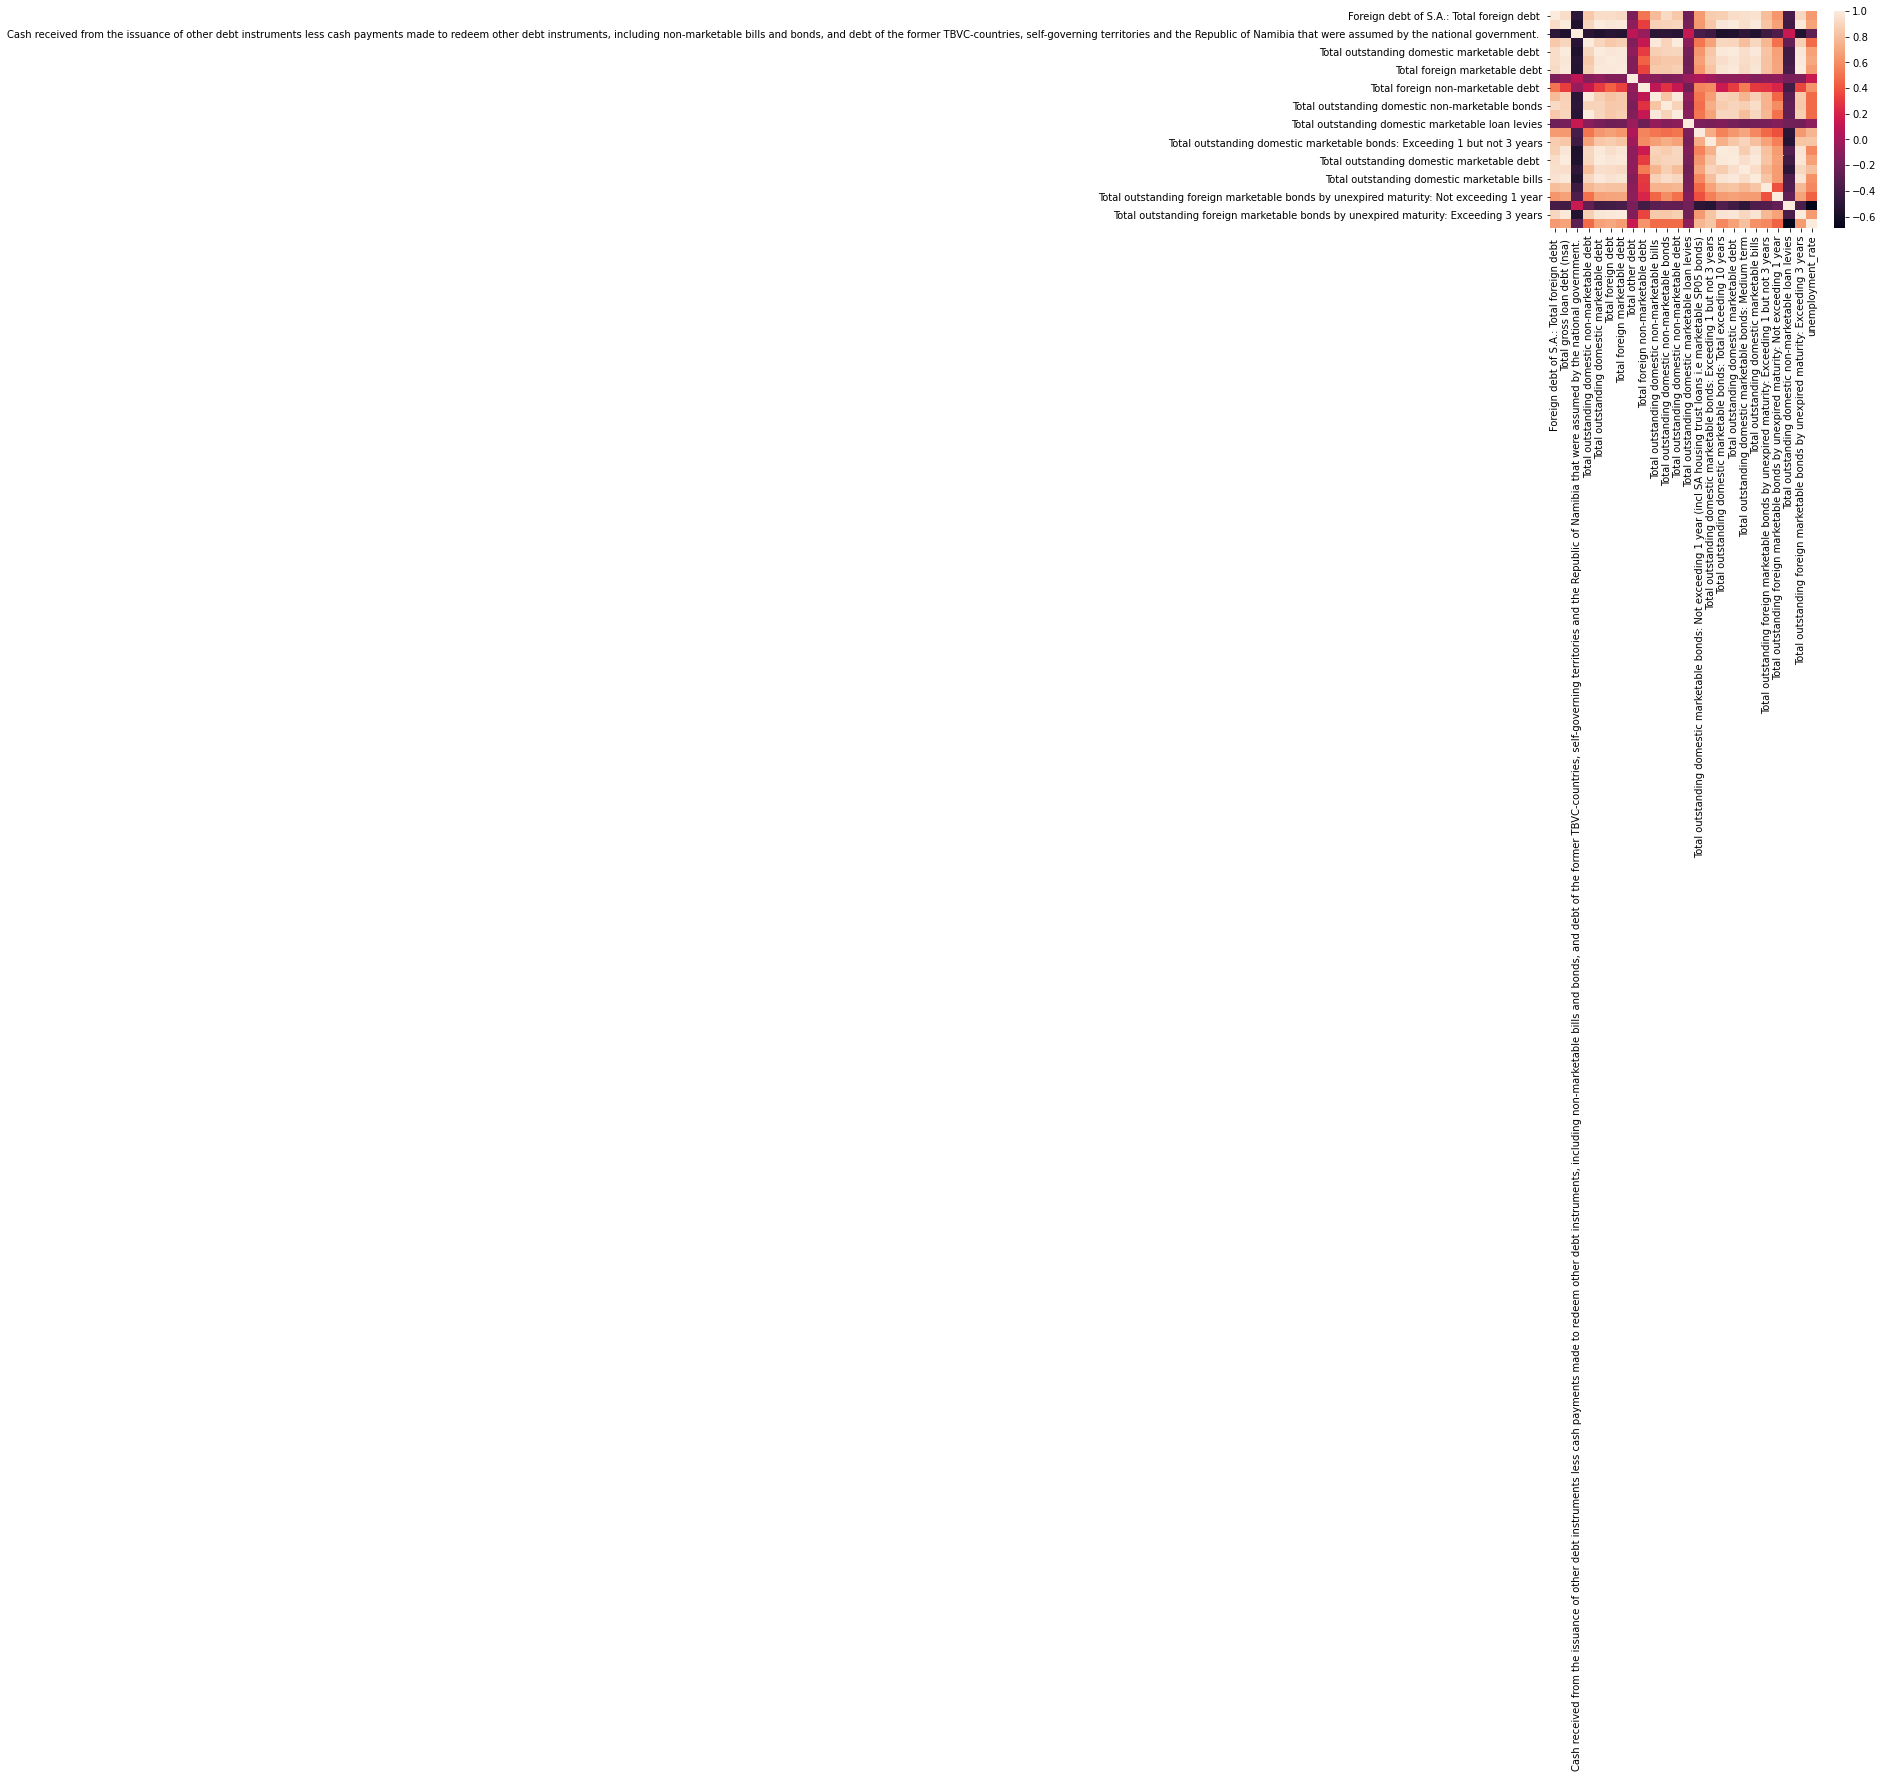

In [60]:
sns.heatmap(df.corr())

# Colinearity

In [61]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    

In [283]:
# removing all the corrated values with a correlation value over 0.7
DF_X = df.copy()
correlation(DF_X,0.7)

In [284]:
values = list(DF_X.columns)
keys = list('ABCDEFGH')

zip1 = zip(keys, values)



dictionary = dict(zip1)


print(dictionary)

{'A': 'Foreign debt of S.A.: Total foreign debt ', 'B': 'Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government. ', 'C': 'Total other debt ', 'D': 'Total foreign non-marketable debt ', 'E': 'Total outstanding domestic marketable loan levies', 'F': 'Total outstanding domestic marketable bonds: Not exceeding 1 year (incl SA housing trust loans i.e marketable SP05 bonds)', 'G': 'Total outstanding foreign marketable bonds by unexpired maturity: Not exceeding 1 year', 'H': 'Total outstanding domestic non-marketable loan levies'}


In [285]:
DF_X.columns = keys
DF_Y.columns = ['unemployment_rate']

# Modelling
## Stepwise regression

In [286]:
X_train, X_test, y_train, y_test = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)
def model_fit(X,y):    
    #no of features
    feature_list=np.arange(1, len(X_train.columns))            
    high_score=0
    #Variable to store the optimum features
    optimum_no_features=0           
    score_list =[]
    for n in range(len(feature_list)):
        model = LinearRegression()
        rfe = RFE(model,feature_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        # R2 score for measurement
        score = r2_score(y_train, model.predict(X_train_rfe))
        score_list.append(score)
        
        if n % 10 == 0:
            print(n,score)
            
        if(score>high_score):
            high_score = score  
            optimum_no_features = feature_list[n]
    return score_list, optimum_no_features 
#print("Optimum number of features: %d" %nof)
#print("Score with %d features: %f" % (nof, high_score))

In [287]:
# Train model using X_train, y_train
X_train
scores_list, optimum_no_features = model_fit(X_train,y_train)

0 0.48593002562915577


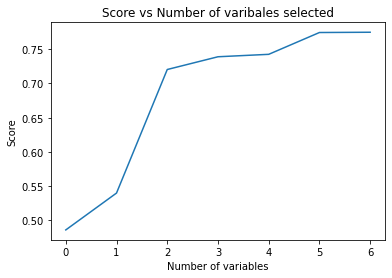

In [288]:
# Plot scores list
def plt_plot(values,title, x_label, y_label):
    
    plt.plot(values)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
plt_plot(scores_list, 'Score vs Number of varibales selected','Number of variables', 'Score')

In [289]:
# fit final model using optimum number of features from prev function

def final_model(optimum_no_features, X_train, y_train):
    cols = list(DF_X.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, optimum_no_features)             
    #Transforming data using RFE
    x_fitted = rfe.fit_transform(X_train,y_train)  
    #Fitting the data to model
    model.fit(x_fitted,y_train)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

In [290]:
selected_features, model, rfe = final_model(optimum_no_features, X_train, y_train)

In [291]:
y_train_predicted = model.predict(rfe.transform((X_train)))


## Model Fit Analaysis

# Post-Stepwise Regression

## Residual Analysis

In [294]:
residuals = y_train-y_train_predicted
residuals

,unemployment_rate
Date,
1976-08-01,-5.629983
1991-01-12,-1.471032
1996-04-01,-0.674359
1976-01-06,-5.829179
2006-10-01,-1.693501
...,...
2018-01-03,5.169736
1982-03-01,1.172458
2009-08-01,0.740346


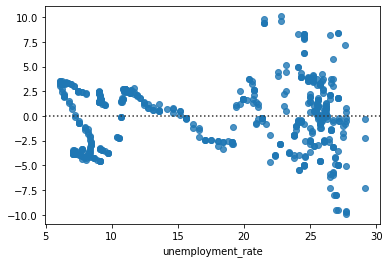

In [295]:
ax = sns.residplot(y_train,y_train_predicted)

### We can apply normal probability plot to assess how the data (error) depart from normality visually:

In [307]:
import statsmodels.formula.api as sm

In [308]:
formula_features = ' + '.join(list(selected_features))
formula = 'unemployment_rate~'+ formula_features

In [309]:
# Add y back to df

X_y_new_train = pd.concat([X_train,y_train], axis=1)

In [310]:
X_train_y_target = pd.concat([X_train, y_train], axis=1)

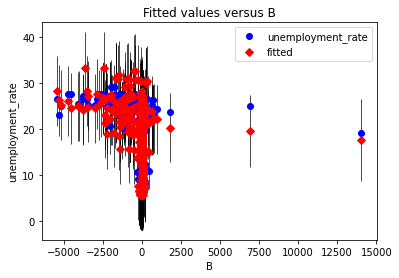

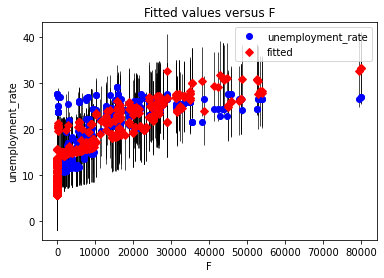

In [311]:
results = sm.ols(formula=formula,data = X_train_y_target).fit()
import statsmodels.graphics as smgraphics

axss = smgraphics.regressionplots.plot_fit(results, 1)
_ = smgraphics.regressionplots.plot_fit(results,5)


In [312]:
Y_ols_pred=results.predict(X_train)
Y_ols_pred = pd.DataFrame(Y_ols_pred)
Y_ols_pred.columns = ['unemployment_rate']

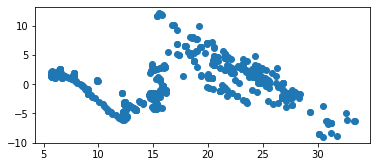

In [313]:
pred_val = results.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(6,2.5))

residuals.shape
_ = ax.scatter(pred_val, residuals)

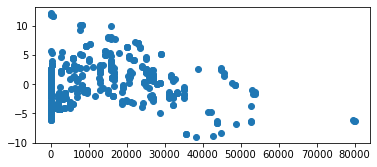

In [314]:
fig, ax1 = plt.subplots(figsize=(6,2.5))
_ = ax1.scatter(X_train.iloc[:,5:6], residuals)

<AxesSubplot:ylabel='Density'>

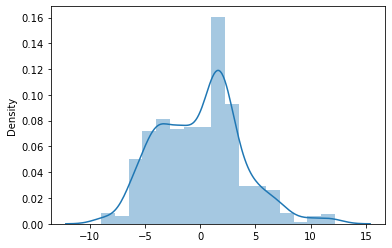

In [315]:
# Plot shows that the residuals are normally distributed
sns.distplot(residuals)

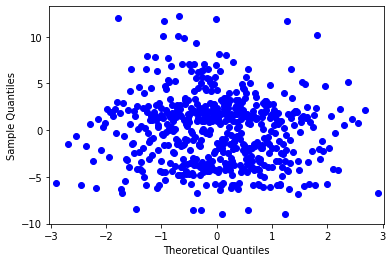

In [316]:
import statsmodels.api as sm
_ = sm.qqplot(residuals)

### Outlier Detection and removal

In [317]:
test = results.outlier_test()
outliers = ((x[i],y[i]) for i,t in enumerate(test) if t[2] < 0.5)

In [319]:
X_train, X_test, y_train, y_test = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)

In [320]:
outliers =(i for i,t in enumerate(test.iloc[:,2]) if t < 0.5)

In [321]:
# Index of Outliers
outliers_list = list(outliers)

In [322]:
# Remove outliers
X_train = pd.DataFrame(np.delete(X_train.values, outliers_list,0))
y_train = pd.DataFrame(np.delete(y_train.values, outliers_list,0))
len(X_train)

555

## Final Model

In [323]:
X_train, X_test, y_train, y_test = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)

final_model = rlm(formula, data=X_train_y_target,
                      M=sm.robust.norms.HuberT()).fit(conv="weights")

In [324]:
X_train

,A,B,C,D,E,F,G,H
Date,,,,,,,,
1976-08-01,0.0,50.0,0.0,792.0,0.0,0.0,14.0,605.0
1991-01-12,0.0,-5.0,0.0,565.0,705.0,3864.0,648.0,3.0
1996-04-01,0.0,-37.0,8683.0,4274.0,0.0,13826.0,2351.0,3.0
1976-01-06,0.0,5.0,0.0,609.0,0.0,0.0,17.0,528.0
2006-10-01,60372.0,-43.0,319.0,23290.0,0.0,34998.0,3793.0,3.0
...,...,...,...,...,...,...,...,...
2018-01-03,183311.0,-1411.0,46.0,3765.0,0.0,29039.0,0.0,0.0
1982-03-01,0.0,5.0,0.0,801.0,0.0,0.0,103.0,1796.0
2009-08-01,82893.0,770.0,109.0,25568.0,0.0,12941.0,0.0,0.0


In [325]:
final_model_predicted = final_model.predict(X_test)

In [326]:
params = np.array(final_model.params)

In [327]:
metrics.r2_score(y_test, final_model_predicted)

0.775175305161635

In [328]:
def print_p_values(x_test, y_test, predicted, params):
    """
    Calculates the p value, based on https://stackoverflow.com/a/42677750/9260653
    """
    newX = np.append(np.ones((len(x_test),1)), x_test, axis=1)
    MSE = mean_squared_error(y_test.values,predicted.values)

    var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)[:-1]
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-Values"] = [params,sd_b,ts_b,p_values]
    print(myDF3.iloc[1])

In [329]:
print_p_values(X_test, y_test, final_model_predicted, params)

Coefficients       -0.0001
Standard Errors     0.0000
t values          -14.5650
P-Values            0.0000
Name: 1, dtype: float64


 The test for $H_{0}$ byusing the following statistic:
$$
F_{0} = \frac{MS_R}{MS_E}
$$
where $MS_R$ is the regression mean square and $MS_E$ is the error mean square.
<br>
The null hypothesis, $H_{0}$, is rejected if the calculated statistic. $f_{0}, is usch that$
$$
F_{0} > f
$$
I will now test my hypothesist using $F$

In [330]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The fvalue is " + str(fvalue[0][0]))

In [331]:
fstat_test(final_model)

The fvalue is 304.5722402427278


In [332]:
degresOfFreedom = len(X_train) - (len(X_train.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

3.0122292124661048

As shown above, $F_{0} = 304.572$ and $f = 3.01217$.
<br>
<br>
Since $F_0$ > $f$, $H_{0}$ is rejected and it is concluded that at least one $\beta_{i}$ cofficient is significant. In other words, it is concluded that a regression model exists between the exploratory and response variables